In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import imblearn
from collections import Counter 
from imblearn.over_sampling import SMOTE
from collections import OrderedDict

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [2]:
# Read in the full Cal Fire dataset using the JSON file
json_wildfires = pd.read_json('https://www.fire.ca.gov/umbraco/api/IncidentApi/List?inactive=true', orient='records')

# Filter for wildfires that are no longer active
json_wildfires = json_wildfires[json_wildfires['IsActive'] == False]

# Drop rows with 'nan' in AcresBurned
json_wildfires = json_wildfires[json_wildfires['AcresBurned'].notna()]

# Drop rows with no county entered and reset index
json_wildfires = json_wildfires[json_wildfires['County'] != '']
json_wildfires = json_wildfires.reset_index(drop=True)

# Convert StartedDateOnly to a date object
json_wildfires['StartedDateOnly'] = pd.to_datetime(json_wildfires['StartedDateOnly'])

# Add month and year columns
json_wildfires['month'] = json_wildfires['StartedDateOnly'].dt.month
json_wildfires['year'] = json_wildfires['StartedDateOnly'].dt.year

# Drop rows with year of '1969' (incorrect data) and reset index
json_wildfires = json_wildfires[json_wildfires['year'] != 1969]
json_wildfires = json_wildfires.reset_index(drop=True)

# Drop irrelevant columns
json_wildfires = json_wildfires[['County', 'AcresBurned', 'month', 'year']]

# Calculate the total acres burned for every county in each month of each year
json_wildfires = json_wildfires.groupby(['County', 'month', 'year'], as_index=False)['AcresBurned'].sum()

# Read in the 2003-2012 and 2013-2020 weather data
weather_data_2012 = pd.read_csv('weather_data_2012.csv', skiprows=10)
weather_data_2020 = pd.read_csv('weather_data_2020.csv', skiprows=10)

# Convert dates to a date object
weather_data_2012['Date'] = pd.to_datetime(weather_data_2012['Date'])
weather_data_2020['Date'] = pd.to_datetime(weather_data_2020['Date'])

# Add month and year columns
weather_data_2012['month'] = weather_data_2012['Date'].dt.month
weather_data_2012['year'] = weather_data_2012['Date'].dt.year
weather_data_2020['month'] = weather_data_2020['Date'].dt.month
weather_data_2020['year'] = weather_data_2020['Date'].dt.year

# Drop irrelevant weather columns
weather_data_2012.drop(['Longitude', 'Latitude', 'Date'], axis=1, inplace=True)
weather_data_2020.drop(['Longitude', 'Latitude', 'Date'], axis=1, inplace=True)

# Concatenate the two weather dataframes
weather_data = pd.concat([weather_data_2012, weather_data_2020],ignore_index=True)

# Join the weather data on the wildfire data
json_wildfires = pd.merge(json_wildfires, weather_data,  how='left', left_on=['County','month','year'], right_on = ['Name','month','year'])
json_wildfires.drop(['Name'], axis=1, inplace=True)

# Read in the county data
county_data = pd.read_csv('ca_county_data.csv', engine='python', dtype={'County': 'str' })
county_data['Population(2010)'] = county_data['Population(2010)'].str.replace(',', '').astype(float)
county_data['Land Area(mi2)'] = county_data['Land Area(mi2)'].str.replace(',', '').astype(float)
county_data['Water Area(mi2)'] = county_data['Water Area(mi2)'].str.replace(',', '').astype(float)
county_data['Total Area(mi2)'] = county_data['Total Area(mi2)'].str.replace(',', '').astype(float)
county_data.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

# Join the wildfire data on the county data
json_wildfires = json_wildfires.merge(county_data, how='left', left_on='County', right_on='County')

# One-hot encode the counties
one_hot_counties = pd.get_dummies(json_wildfires['County'])
json_wildfires.drop(['County'], axis=1, inplace=True)
json_wildfires = json_wildfires.join(one_hot_counties)

# Drop 'nan' values
json_wildfires.dropna(inplace=True)

json_wildfires

,month,year,AcresBurned,Elevation (ft),ppt (inches),tmin (degrees F),tmean (degrees F),tmax (degrees F),vpdmin (hPa),vpdmax (hPa),Population(2010),Land Area(mi2),Water Area(mi2),Total Area(mi2),Alameda,Alpine,Amador,"Amador, El Dorado",Butte,Calaveras,Colusa,"Colusa, Glenn, Lake, Mendocino","Colusa, Lake, Mendocino",Contra Costa,Del Norte,El Dorado,"El Dorado, Placer","El Dorado, Sacramento",Fresno,Glenn,"Glenn, Mendocino",Humboldt,Imperial,Inyo,"Inyo, Mono",Kern,"Kern, San Luis Obispo","Kern, Ventura",Kings,Lake,"Lake, Colusa","Lake, Napa",Lassen,"Lassen, Modoc","Lassen, Shasta",Los Angeles,"Los Angeles, Ventura",Madera,"Madera, Mariposa",Marin,...,"Napa, Yolo",Nevada,Orange,"Orange, Riverside",Placer,Plumas,Riverside,"Riverside, San Bernardino",Sacramento,San Benito,"San Benito, Monterey",San Bernardino,"San Bernardino, Riverside",San Diego,"San Diego, Riverside",San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,"Santa Barbara, Ventura",Santa Clara,"Santa Clara, Alameda, Contra Costa, San Joaquin, Stanislaus","Santa Clara, Santa Cruz",Santa Cruz,"Santa Cruz, San Mateo",Shasta,"Shasta, Lassen","Shasta, Tehama","Shasta, Trinity",Sierra,Siskiyou,"Siskiyou, Modoc",Solano,Sonoma,"Sonoma, Solano, Lake, Colusa",Stanislaus,State of Nevada,State of Oregon,Sutter,Tehama,"Tehama, Glenn","Tehama, Shasta",Trinity,Tulare,"Tulare, Kern",Tuolumne,"Tuolumne, Calaveras",Ventura,Yolo,Yuba
0,5,2015,242.0,587.0,0.45,49.9,59.3,68.6,1.76,13.26,1510271.0,739.017,82.311,821.328,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,2018,496.0,587.0,0.00,49.5,60.0,70.6,1.46,14.66,1510271.0,739.017,82.311,821.328,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,2010,475.0,587.0,0.00,52.8,65.5,78.2,2.07,21.58,1510271.0,739.017,82.311,821.328,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,2011,175.0,587.0,1.97,51.4,63.4,75.5,1.71,19.26,1510271.0,739.017,82.311,821.328,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,2012,60.0,587.0,0.11,51.0,65.3,79.5,2.23,25.53,1510271.0,739.017,82.311,821.328,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1513,8,2020,600.0,528.0,0.00,67.5,81.1,94.8,9.48,41.83,72155.0,631.839,11.969,643.808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1514,9,2017,26.0,528.0,0.04,62.1,74.5,87.0,7.06,31.68,72155.0,631.839,11.969,643.808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1515,9,2020,1311.0,528.0,0.00,63.1,76.2,89.4,8.60,35.34,72155.0,631.839,11.969,643.808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1516,10,2017,9989.0,528.0,0.54,51.9,65.4,79.0,5.12,25.31,72155.0,631.839,11.969,643.808,0,0,0,0,0,0,0,0,0

In [3]:
county_data

,County,Population(2010),Land Area(mi2),Water Area(mi2),Total Area(mi2)
0,Alameda,1510271.0,739.017,82.311,821.328
1,Alpine,1175.0,738.332,4.848,743.180
2,Amador,38091.0,594.583,11.373,605.956
3,Butte,220000.0,1636.460,40.667,1677.130
4,Calaveras,45578.0,1020.010,16.915,1036.930
5,Colusa,21419.0,1150.730,5.630,1156.360
6,Contra Costa,1049025.0,715.937,87.833,803.770
7,Del Norte,28610.0,1006.370,223.370,1229.740
8,El Dorado,181058.0,1707.880,78.473,1786.360
9,Fresno,930450.0,5957.990,53.211,6011.200


In [4]:
# Add classification labels for each row in the dataframe
nwcg_classes = [-1, 10, 100, 300, 1000, 5000, 100000, 400000]
labels = list(range(1,8))
json_wildfires['BinnedAcresBurned'] = pd.cut(json_wildfires['AcresBurned'], bins=nwcg_classes, labels=labels)

In [5]:
# Get min / max year for description in writeup
json_wildfires['year'].max() # 2003-2020

2020

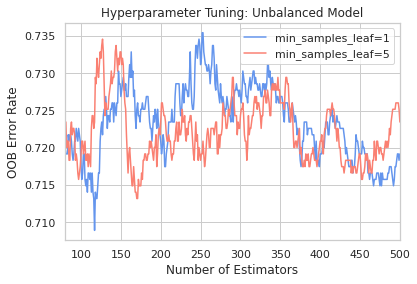

In [6]:
# Split the data into X and y
X = json_wildfires.drop(['AcresBurned', 'BinnedAcresBurned'], axis=1)
y = json_wildfires['BinnedAcresBurned']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an ensemble of random forest classifiers
ensemble_clfs = [
    (1,
        RandomForestClassifier(warm_start=True, 
                               min_samples_leaf=1,
                               oob_score=True,
                               max_depth=10,
                               random_state=0)),
    (5,
        RandomForestClassifier(warm_start=True, 
                               min_samples_leaf=5,
                               oob_score=True,
                               max_depth=10,
                               random_state=0))
]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 80
max_estimators = 500

# Loop through the classifiers and number of estimators
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i) 
        clf.fit(X_train, y_train)

        # Record the OOB error for each model. Error is 1 - oob_score
        # oob_score: score of the training dataset obtained using an 
        # out-of-bag estimate.
        # OOB error rate is % of num_missclassified/total observations
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    if label==1:
        color = 'cornflowerblue'
    else:
        color = 'salmon'
    plt.plot(xs, ys, label=f'min_samples_leaf={label}', color=color)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("Number of Estimators")
plt.title("Hyperparameter Tuning: Unbalanced Model")
plt.ylabel("OOB Error Rate")
plt.legend(loc="upper right")
plt.savefig('hyperparameter_unbalanced.png')

In [7]:
# Find the optimal number of estimators and min samples leaf
err = 100
best_num_estimators = 0
for label, clf_err in error_rate.items():
    num_estimators, error = min(clf_err, key=lambda n: (n[1], -n[0]))
    if error<err: err=error; best_num_estimators = num_estimators; best_leaf = label

print(f'Optimum num of estimators: {best_num_estimators} \nmin_samples_leaf: {best_leaf}')

# Fit a new random forest classifier using these optimal parameters
estimators_rf = RandomForestClassifier(n_estimators= best_num_estimators,
                                    random_state=0,
                                    oob_score=True,
                                    min_samples_leaf=best_leaf,
                                    max_features='sqrt') 

# Fit the model on the entire data
estimators_rf.fit(X_train, y_train)

# Get the predicted classification values
y_test_pred = estimators_rf.predict(X_test)

# Calculate the test set accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Educated RF accuracy on test set: {accuracy:.4f}')

Optimum num of estimators: 117 
min_samples_leaf: 1
Educated RF accuracy on test set: 0.3082


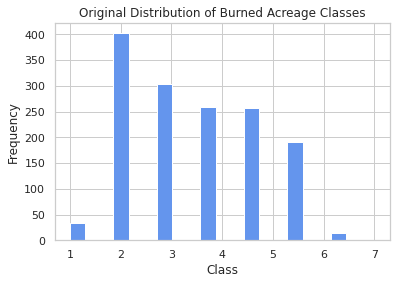

In [8]:
import collections
# Get breakdown of bins pre-SMOTE
#wf_data_acres.nwcg_class.hist(bins = 7)
json_wildfires['BinnedAcresBurned'].hist(bins=7, width=0.3, color='cornflowerblue')
plt.title("Original Distribution of Burned Acreage Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.savefig('distribution_unbalanced.png')

Comparing predicted labels vs. actual labels (Pre-SMOTE Model): 


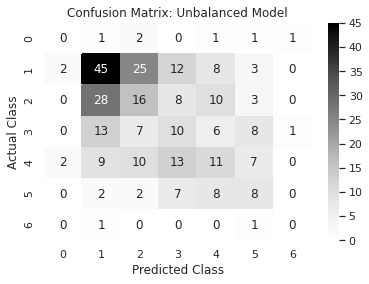

In [9]:
# Get confusion matrix for pre-SMOTE
from sklearn.metrics import confusion_matrix

print("Comparing predicted labels vs. actual labels (Pre-SMOTE Model): ")
ax = plt.axes()

cf_matrix_v1 = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf_matrix_v1, annot=True, cmap='Greys', ax=ax)
ax.set_title('Confusion Matrix: Unbalanced Model')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
plt.show()

In [10]:
# Count the number of rows that fall into each category
counter = Counter(json_wildfires.BinnedAcresBurned)

# Oversample using SMOTE
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)
y_smote = LabelEncoder().fit_transform(y_smote)

# Count the number of rows that fall into each category after overlampling
counter_smote = Counter(y_smote)

print(counter_smote)

Counter({2: 402, 3: 402, 1: 402, 5: 402, 4: 402, 0: 402, 6: 402})


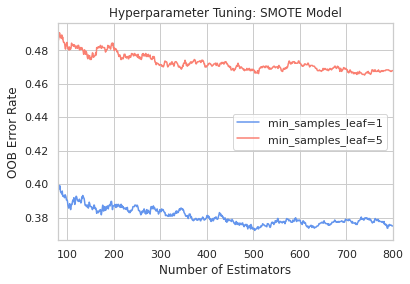

In [11]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Create an ensemble of random forest classifiers
ensemble_clfs = [
    (1,
        RandomForestClassifier(warm_start=True, 
                               min_samples_leaf=1,
                               oob_score=True,
                               max_depth=20,
                               random_state=0)),
    (5,
        RandomForestClassifier(warm_start=True, 
                               min_samples_leaf=5,
                               oob_score=True,
                               max_depth=20,
                               random_state=0))
]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 80
max_estimators = 800

# Loop through the classifiers and number of estimators
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i) 
        clf.fit(X_train, y_train)

        # Record the OOB error for each model. Error is 1 - oob_score
        # oob_score: score of the training dataset obtained using an 
        # out-of-bag estimate.
        # OOB error rate is % of num_missclassified/total observations
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    if label==1:
        color = 'cornflowerblue'
    else:
        color='salmon'
    plt.plot(xs, ys, label=f'min_samples_leaf={label}', color=color)
plt.title("Hyperparameter Tuning: SMOTE Model")
plt.xlim(min_estimators, max_estimators)
plt.xlabel("Number of Estimators")
plt.ylabel("OOB Error Rate")
plt.legend(loc="best")
plt.show()

In [12]:
X_train.head()

,month,year,Elevation (ft),ppt (inches),tmin (degrees F),tmean (degrees F),tmax (degrees F),vpdmin (hPa),vpdmax (hPa),Population(2010),Land Area(mi2),Water Area(mi2),Total Area(mi2),Alameda,Alpine,Amador,"Amador, El Dorado",Butte,Calaveras,Colusa,"Colusa, Glenn, Lake, Mendocino","Colusa, Lake, Mendocino",Contra Costa,Del Norte,El Dorado,"El Dorado, Placer","El Dorado, Sacramento",Fresno,Glenn,"Glenn, Mendocino",Humboldt,Imperial,Inyo,"Inyo, Mono",Kern,"Kern, San Luis Obispo","Kern, Ventura",Kings,Lake,"Lake, Colusa","Lake, Napa",Lassen,"Lassen, Modoc","Lassen, Shasta",Los Angeles,"Los Angeles, Ventura",Madera,"Madera, Mariposa",Marin,Mariposa,...,"Napa, Yolo",Nevada,Orange,"Orange, Riverside",Placer,Plumas,Riverside,"Riverside, San Bernardino",Sacramento,San Benito,"San Benito, Monterey",San Bernardino,"San Bernardino, Riverside",San Diego,"San Diego, Riverside",San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,"Santa Barbara, Ventura",Santa Clara,"Santa Clara, Alameda, Contra Costa, San Joaquin, Stanislaus","Santa Clara, Santa Cruz",Santa Cruz,"Santa Cruz, San Mateo",Shasta,"Shasta, Lassen","Shasta, Tehama","Shasta, Trinity",Sierra,Siskiyou,"Siskiyou, Modoc",Solano,Sonoma,"Sonoma, Solano, Lake, Colusa",Stanislaus,State of Nevada,State of Oregon,Sutter,Tehama,"Tehama, Glenn","Tehama, Shasta",Trinity,Tulare,"Tulare, Kern",Tuolumne,"Tuolumne, Calaveras",Ventura,Yolo,Yuba
1744,8,2015,7721.658523,0.278862,50.625041,63.504553,76.481789,8.587626,26.569886,1222.008173,743.223627,4.942426,748.166053,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2185,7,2010,2715.586325,0.196233,56.815483,75.494166,94.162045,6.828134,48.339590,44973.244415,5709.880642,63.779990,5773.655820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2370,8,2013,564.423092,0.034206,56.589532,70.894157,85.098783,6.134576,33.692619,497021.974647,1541.020079,118.054111,1659.075331,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2513,7,2006,2122.491248,0.008660,63.612268,74.142209,84.672149,9.453226,29.022872,477429.630564,2615.540677,961.678103,3577.218914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1025,8,2016,1844.000000,0.000000,50.700000,71.800000,92.900000,4.440000,44.620000,269637.000000,3298.570000,316.980000,3615.550000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Find the optimal number of estimators and min samples leaf
err = 100
best_num_estimators = 0
for label, clf_err in error_rate.items():
    num_estimators, error = min(clf_err, key=lambda n: (n[1], -n[0]))
    if error<err: err=error; best_num_estimators = num_estimators; best_leaf = label

print(f'Optimum num of estimators: {best_num_estimators} \nmin_samples_leaf: {best_leaf}')

# Fit a new random forest classifier using these optimal parameters
estimators_rf = RandomForestClassifier(n_estimators=best_num_estimators,
                                    random_state=0,
                                    oob_score=True,
                                    min_samples_leaf=best_leaf,
                                    max_features='sqrt') 

# Fit the model on the entire data
estimators_rf.fit(X_train, y_train)

# Get the predicted classification values
y_test_pred = estimators_rf.predict(X_test)

# Calculate the test set accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Educated RF accuracy on test set after oversampling using SMOTE: {accuracy:.4f}')

Optimum num of estimators: 503 
min_samples_leaf: 1
Educated RF accuracy on test set after oversampling using SMOTE: 0.5950


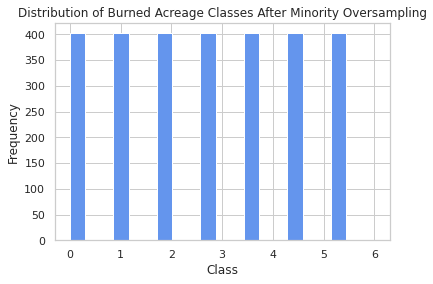

In [14]:
# Get breakdown of bins post-SMOTE
plt.hist(y_smote, bins = 7, width=0.3, color='cornflowerblue')
plt.title("Distribution of Burned Acreage Classes After Minority Oversampling")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

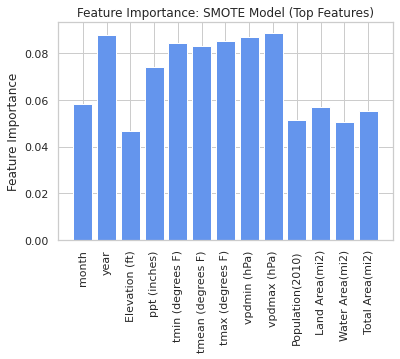

In [15]:
# Get feature importance visualization 
plt.bar(X_train.columns[:13], estimators_rf.feature_importances_[:13], color='cornflowerblue')
plt.title('Feature Importance: SMOTE Model (Top Features)')
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.show()

Comparing predicted labels vs. actual labels (SMOTE Model): 


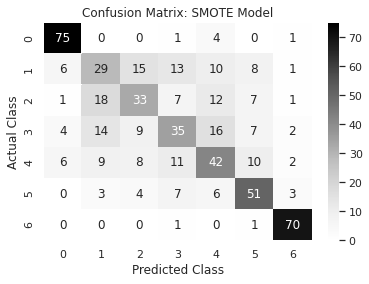

In [16]:
# Get confusion matrix for SMOTE

# Analyze best decision tree
#best_dt_v1 = DecisionTreeClassifier(max_depth= 3)
#best_dt_v1.fit(X_train, y_train)
#y_pred_v1 = best_dt_v1.predict(X_test)
print( "Comparing predicted labels vs. actual labels (SMOTE Model): ")
ax = plt.axes()
cf_matrix_smote = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cf_matrix_smote, annot=True, cmap='Greys', ax=ax)
ax.set_title('Confusion Matrix: SMOTE Model')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
plt.show()

In [17]:
# Get precision/recall by class
recall = np.diag(cf_matrix_smote) / np.sum(cf_matrix_smote, axis = 1)
precision = np.diag(cf_matrix_smote) / np.sum(cf_matrix_smote, axis = 0)
print(recall)
print(precision)

[0.92592593 0.35365854 0.41772152 0.40229885 0.47727273 0.68918919
 0.97222222]
[0.81521739 0.39726027 0.47826087 0.46666667 0.46666667 0.60714286
 0.875     ]


In [18]:
# Get predictions on the original data and join
all_pred = estimators_rf.predict(X)
prediction_df = X.copy()
prediction_df['prediction'] = all_pred

# # For each county and each month, count the number of predictions in each class (0-6)
# for i, row in prediction_df.iterrows():
#     print(row['c1'], row['c2'])

# Calculate a risk metric between 0 and 1 that averages historical predictions
# helloooo. So I am trying to count, for each county and each month, the number of times that (county-month) pair was classified into each class (0-6)
# so this is a bit tricky, but I'm thinking we loop through this 'prediction_df', which contains the X and predictions for all our original data
'''
County | Month | 0 | 1| 2|Classification Distribution
-------------------------------------------- 
str    | int   | {0: x, 1: y,..., 6: z}

'''
# gotcha! 
# trying to see if there is a way to reverse One hot encoding 

# get column indices corresponding to one-hot encoded counties
county_cols = ['Alameda', 'Alpine', 'Amador',
       'Amador, El Dorado', 'Butte', 'Calaveras', 'Colusa',
       'Colusa, Glenn, Lake, Mendocino', 'Colusa, Lake, Mendocino',
       'Contra Costa', 'Del Norte', 'El Dorado', 'El Dorado, Placer',
       'El Dorado, Sacramento', 'Fresno', 'Glenn', 'Glenn, Mendocino',
       'Humboldt', 'Imperial', 'Inyo', 'Inyo, Mono', 'Kern',
       'Kern, San Luis Obispo', 'Kern, Ventura', 'Kings', 'Lake',
       'Lake, Colusa', 'Lake, Napa', 'Lassen', 'Lassen, Modoc',
       'Lassen, Shasta', 'Los Angeles', 'Los Angeles, Ventura', 'Madera',
       'Madera, Mariposa', 'Marin', 'Mariposa', 'Mendocino',
       'Mendocino, Humboldt, Trinity, Tehama, Glenn, Lake, Colusa',
       'Merced', 'Mexico', 'Mexico, San Diego', 'Modoc', 'Mono',
       'Monterey', 'Monterey, San Benito', 'Monterey, San Luis Obispo',
       'Napa', 'Napa, Lake', 'Napa, Solano', 'Napa, Sonoma',
       'Napa, Sonoma, Lake, Yolo, Solano', 'Napa, Yolo', 'Nevada',
       'Orange', 'Orange, Riverside', 'Placer', 'Plumas', 'Riverside',
       'Riverside, San Bernardino', 'Sacramento', 'San Benito',
       'San Benito, Monterey', 'San Bernardino',
       'San Bernardino, Riverside', 'San Diego', 'San Diego, Riverside',
       'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara',
       'Santa Barbara, Ventura', 'Santa Clara',
       'Santa Clara, Alameda, Contra Costa, San Joaquin, Stanislaus',
       'Santa Clara, Santa Cruz', 'Santa Cruz', 'Santa Cruz, San Mateo',
       'Shasta', 'Shasta, Lassen', 'Shasta, Tehama', 'Shasta, Trinity',
       'Sierra', 'Siskiyou', 'Siskiyou, Modoc', 'Solano', 'Sonoma',
       'Sonoma, Solano, Lake, Colusa', 'Stanislaus', 'State of Nevada',
       'State of Oregon', 'Sutter', 'Tehama', 'Tehama, Glenn',
       'Tehama, Shasta', 'Trinity', 'Tulare', 'Tulare, Kern', 'Tuolumne',
       'Tuolumne, Calaveras', 'Ventura', 'Yolo', 'Yuba']

prediction_df = prediction_df.drop(['Elevation (ft)', 'ppt (inches)', 'tmin (degrees F)', 'tmean (degrees F)', 'tmax (degrees F)', 'vpdmin (hPa)', 'vpdmax (hPa)', 'Population(2010)', 'Land Area(mi2)', 'Water Area(mi2)', 'Total Area(mi2)'], axis = 1)
# make new county column
prediction_df['county'] = ""

def add_county(County_name):
    
    prediction_df['county'] = np.where(prediction_df[County_name]== 1, County_name, prediction_df['county'] )

for c in county_cols: 
    add_county(c)

prediction_df = prediction_df.drop(county_cols, axis = 1)
# idea - could we just save the pre-one-hot encoded table above and remerge them together down here?
# jk it worked

In [19]:
prediction_df

,month,year,prediction,county
0,5,2015,2,Alameda
1,5,2018,3,Alameda
2,6,2010,3,Alameda
3,6,2011,2,Alameda
4,6,2012,1,Alameda
...,...,...,...,...
1513,8,2020,3,Yuba
1514,9,2017,1,Yuba
1515,9,2020,4,Yuba
1516,10,2017,5,Yuba


In [20]:
prediction_df.columns.values

array(['month', 'year', 'prediction', 'county'], dtype=object)

In [21]:
prediction_df.head()

,month,year,prediction,county
0,5,2015,2,Alameda
1,5,2018,3,Alameda
2,6,2010,3,Alameda
3,6,2011,2,Alameda
4,6,2012,1,Alameda


In [22]:
# Construct table with one row per county/month pair

# Identify months
months = pd.Series(prediction_df.month.unique(), name = 'month').to_frame()

# identify years
years = pd.Series(prediction_df.year.unique(), name = 'year').to_frame()

# Identify counties
counties = pd.Series(prediction_df.county.unique(), name = 'county').to_frame()

# Outer join to add in rows
months['key'] = 1
years['key'] = 1
counties['key'] = 1
  
# to obtain the cross join we will merge  
# on the key and drop it. 
interim = pd.merge(months, years, on ='key')
interim['key'] = 1
county_year_month_map = pd.merge(interim, counties, on ='key').drop("key", 1)


#county_year_month_map = 

 #= pd.concat([months, years, counties], axis=1)
county_year_month_map.shape

(12312, 3)

In [23]:
# Combine county year month map with risk scores, force to zero where obs doesn't exist
#prediction_df.head()

master_predictions = pd.merge(county_year_month_map, prediction_df, how = 'left', left_on = ['month', 'year', 'county'], right_on = ['month', 'year', 'county'])

# Fill nans with zeros
master_predictions['prediction'] = master_predictions['prediction'].fillna(0)
master_predictions.head()

,month,year,county,prediction
0,5,2015,Alameda,2.0
1,5,2015,Alpine,0.0
2,5,2015,Amador,0.0
3,5,2015,Butte,0.0
4,5,2015,Calaveras,0.0


In [24]:
# number of rows we should have
len(prediction_df.county.unique()) * len(prediction_df.year.unique()) * 12 #12312
master_predictions.shape


(12312, 4)

In [25]:
prediction_df = master_predictions.drop(['year'], axis = 1)

pred_agg = prediction_df.groupby(['month', 'county'], as_index=False).mean()

pred_agg.head()
#pred_agg.shape

,month,county,prediction
0,1,Alameda,0.000000
1,1,Alpine,0.000000
2,1,Amador,0.000000
3,1,Butte,0.111111
4,1,Calaveras,0.000000


In [26]:
pred_agg.shape


(684, 3)

In [27]:
pred_agg.to_csv("pred_agg.csv")
pred_agg.to_csv (path_or_buf="pred_agg.csv", index = False, header=True)